## WEB SCRAPING RESULTS

In the USA media of different views and political opinions are widely represented and they can report news from so various perspectives that any reader is able to choose favorite media according to his/her own preferences. So, I decided to benefit from this variety and gather headlines from all possible political segments:

1. CNN - left;
2. CBS - lean left;
3. New York Times - lean left;
4. Real Clear Politics - center;
5. The Epoch Times - lean right;
6. National Review - right.

It was supposed that this way of gathering database would provide balanced data and all views would be equally represented. But, performing web scraping I faced following obstacles:

- some media mention Russia in regular reports about coronavirus situation in the world, so, there are more articles mentioning Russia than in media without coronavirus reports;

- it looks like different media use different search methods on their websites that results in articles with various levels of relevance to the topic;

- certainly, size of media plays significant role, for instance, CNN publishes in general more articles than Real Clear Politics.


Nevertheless, I used Selenium library to perform web scraping and gathered in total 11 941 headlines of articles published from 01.01.2020 to 20.04.2021 (the date when I started this project). The Notebook with scraping code and details is [here](https://github.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/blob/main/Headlines%20web%20scraping.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from PIL import Image

# for frequency counts
from collections import Counter

# for bigrams, conditional frequency distribution and beyond
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# for word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# for (one way of) keyword extraction
from sklearn import feature_extraction
from nltk.stem.snowball import SnowballStemmer

from nltk import PorterStemmer
from nltk import WordNetLemmatizer

import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random


nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Samsung\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data pre-processing 
### Import files


In [2]:
cbs_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_CBS.txt'
cnn_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_CNN.txt'
et_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_ET.txt'
nr_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_NR.txt'
nyt_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_NT.txt'
rcp_file = 'https://raw.githubusercontent.com/ElinaAizenberg/Machine-Learning-vs-Propaganda---Project/main/data/Russia_headlines_RCP.txt'

CNN = pd.read_csv(cnn_file, delimiter = "\t", header = None, names = ['headline'])
CBS = pd.read_csv(cbs_file, delimiter = "\t", header = None, names = ['headline'])

CBS = CBS.iloc[::2] #CBS file contained also date-lines

NYT = pd.read_csv(nyt_file, delimiter = "\t", header = None, names = ['headline'])
RCP = pd.read_csv(rcp_file, delimiter = "\t", header = None, names = ['headline'])
ET = pd.read_csv(et_file, delimiter = "\t", header = None, names = ['headline'])
NR = pd.read_csv(nr_file, delimiter = "\t", header = None, names = ['headline'])

### Drop duplicates

In [3]:
media = {'CNN':CNN, 'CBS':CBS,'NYT':NYT,'RCP':RCP,'ET':ET, 'NR':NR}

def drop_duplicates(df, df_name):
    print('Amount of rows in {}-file before droping duplicates - {}.'.format(df_name, len(df)))
    df.drop_duplicates(inplace = True, ignore_index = True)
    print('Amount of rows in {}-file after droping duplicates - {}.'.format(df_name, len(df)))

    
for key in media:
    df_name = key
    df = media[key]
    drop_duplicates(df, df_name)
    print('')    

Amount of rows in CNN-file before droping duplicates - 2624.
Amount of rows in CNN-file after droping duplicates - 2537.

Amount of rows in CBS-file before droping duplicates - 781.
Amount of rows in CBS-file after droping duplicates - 775.

Amount of rows in NYT-file before droping duplicates - 4489.
Amount of rows in NYT-file after droping duplicates - 4260.

Amount of rows in RCP-file before droping duplicates - 902.
Amount of rows in RCP-file after droping duplicates - 859.

Amount of rows in ET-file before droping duplicates - 2444.
Amount of rows in ET-file after droping duplicates - 2409.

Amount of rows in NR-file before droping duplicates - 1140.
Amount of rows in NR-file after droping duplicates - 1101.



### Merging files

In [4]:
headlines = pd.concat([CNN,CBS,ET, NR, NYT, RCP], axis = 0, ignore_index=True)

#check
if len(headlines) == len(CNN) + len(CBS) + len(NR) + len(NYT) + len(RCP) + len(ET):
    print('Merging is Ok! The length of the dataset is {} lines.'.format(len(headlines)))
else:
    print('Problem!')
    

Merging is Ok! The length of the dataset is 11941 lines.


**As a result of web scraping and data pre-processing, the distribution of headlines is following:**

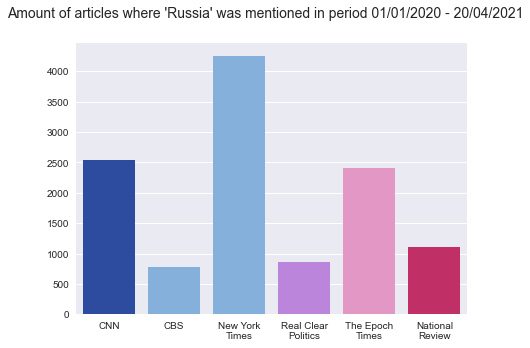

In [5]:
amount_headlines = [len(CNN), len(CBS), len(NYT), len(RCP), len(ET), len(NR)]
media_names = ['CNN', 'CBS','NYT','RCP','ET', 'NR']


fig = plt.figure(figsize = (7,5))
plt.style.use('seaborn')
fig.suptitle("Amount of articles where 'Russia' was mentioned in period 01/01/2020 - 20/04/2021", fontsize=14)

palette = {'CNN':'#1A43B3', 'CBS':'#77B0EA','NYT':'#77B0EA','RCP':'#BF77EA','ET':'#F08AC6', 'NR':'#D81760'}

fig_ax1 = fig.add_subplot()

sns.barplot(x = media_names, y = amount_headlines, ax = fig_ax1, palette = palette)
fig_ax1.set_xticklabels(['CNN','CBS','New York\nTimes', 'Real Clear\nPolitics','The Epoch\nTimes','National\nReview'])

plt.show()

- New York Times mentioned Russia in more than 4 000 articles during 16 months. Brief analysis of headlines showed that this amount is exaggerated because NYT publishes daily briefings, so, if Russia was mentioned in some important news it would be repeated in briefing;

- CNN is second in the rating "US media that loves Russia the most" and it mentioned Russia in more than 2 500 articles. But CNN publishes regular coronavirus news, so, there is a significant amount of  headlines with reports about COVID-19 in different countries;​

- even though Real Clear Plotics mentioned Russia in only 859 articles, the relevance seems to be high and articles really represent what I have been looking for. My favorite headline is **"Apparently The Russians Run The Iowa Democratic Party"**;

- CBS (775 articles) and Real Clear Plotics are almost equal in time spent on news about Russia.

## MOST  FREQUENTLY  USED  WORDS

In this project I use several techniques to analyse headlines:

- calculate the most frequently used words per each media - simple counting with collections.Counter;

- visualize frequently used words across all media in form of word cloud - with collections.Counter and WordCloud;

- calculate and visualize top N uni-grams, bi-grams, tri-grams - with Bag of Words model, CountVectorizer and bar plots;

- calculate the most important words in headlines - with TF-IDF scores;

- define N-clusters of headlines and frequent words inside each cluster - with K-means clustering.


Firstly, let's define the words that were used more often. Obviously, the most frequent words will be 'the', 'is', 'a' and so on. Also, 'media' and 'media's' might be seen as different words, as well as 'Russia' and 'russia'. That is why text analysis requires some pre-processing steps.


**Pre-processing steps before counting:**

1. exclude so called 'stop-words' - list of 153 commonly used words plus manually added words like 'things' and 'facts';

2. also exclude words 'Russia'/'Russian' because it is expected to be massively in headlines, but its frequency do not give valuable information;

3. exclude punctuation and figures;

4. change all words to lower-case;

5. perform replacements, for instance, coronavirus could be also called 'COVID-19' or simply 'virus'. 


**After preparation steps counting can be performed. Firstly, let's compare top-10 words in each media.**


In [6]:
#stop-words list
stop_words = stopwords.words('english')
stop_words += ['russia','russian','fast','says', 'say','things','know', "using", 'fact', 'facts', "think", "thinks", "show", "result", "large", "also", "one", "two", "new", "shown"] # add custom stopwords
replacements = {'covid-19': 'covid', 'coronavirus': 'covid', 'virus': 'covid', 'u':'us'}

#function to calculate most frequently used words in headlines of single media
def most_frequent_words(media, n_words, media_name):
        
    text = media.headline.tolist()
    text = str(text)
    text = re.sub('[^a-zA-Z]',' ',text)
        
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    tokens = [replacements.get(x, x) for x in tokens]
    
    no_stops = [t for t in tokens if t not in stop_words]
    result = Counter(no_stops).most_common(n_words)
    
    result_df = pd.DataFrame(result, columns=['Word', 'Count'])
    print("The {} most common words are following:\n".format(media_name))
    
    return(result_df)

#print(most_frequent_words(CNN, 10, 'CNN'))


In [7]:
#function to calculate most frequently used words in headlines of all media and present combined results
def most_frequent_words_all_media(n_words):
    all_media_df = pd.DataFrame()
        
    for key, value in media.items():
        text = value.headline.tolist()
        text = str(text)
        text = re.sub('[^a-zA-Z]',' ',text)
                    
        tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
        tokens = [replacements.get(x, x) for x in tokens]
        no_stops = [t for t in tokens if t not in stop_words]
        result = Counter(no_stops).most_common(n_words)
        
        result_df = pd.DataFrame(result, columns = ['Word', 'Count']).Word
        
        all_media_df[key] = result_df
    
    return all_media_df
        
most_frequent_words_all_media(11)

,CNN,CBS,NYT,RCP,ET,NR
0,trump,us,trump,trump,us,trump
1,covid,trump,covid,biden,china,biden
2,us,transcript,us,probe,trump,us
3,news,putin,briefing,media,covid,flynn
4,biden,face,biden,fbi,biden,covid
5,election,nation,china,covid,election,c
6,putin,biden,election,china,chinese,china
7,oil,covid,dies,us,military,fbi
8,world,election,world,collusion,fbi,election
9,china,intel,iran,president,ccp,probe


To my mind, National Review list looks more peculiar than others, primarily, because I cannot remeber mentioning names of Michael Flynn and William Barr in Russian media, while in National Review articles these names are in top-10. 


**Key insights:**

- it seems that despite divergence of views all media associate Russia with presidential election in the USA in 2020 because 'Trump', 'Biden' and 'election' are among top words everywhere. *Here I should mention that US presidential election was the most exciting and inspiring political event in Russia last year. This topic was widely discussed and covered by both state and independent media*;

- obviously, Russian agenda is frequently accomponied by China and Chinese agenda as it is also represented in all 6 columns. In the Epoch Times list you can see even 'ccp' which stands for Chinese Communist Party;

- surprisingly, Russian president's surname, Putin, reached top-positions only in left, lean-left media, while other media mention FBI (Federal Bureau of Investigation) suspiciously often.


**Intermediate conclusion based on the table above: US media and Americans are more interested and involved in their internal news and political situation rather than worring about Russian agenda. Former, potential and current US presidents draw people's attention even when journalists write about Russia.**


I would like to conclude this section of the project with visualization of top-100 most frequently used words in all headlines together in form of a word cloud. You can explore it and make your own conclusions. 

The All media most common words are following:



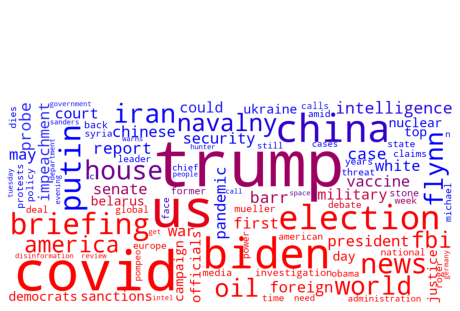

In [8]:
#create a cloud of 100 most frequent words in all headlines 

bag = most_frequent_words(headlines, 100, 'All media') 
bag = bag.loc[bag['Word'] != 'russia'] #exclude 'Russia' as we already know the topic

dict_cloud = dict(bag.values)

# Generate a word cloud image
mask = np.array(Image.open(r'C:\Users\Samsung\Desktop\ДОКУМЕНТЫ\DATA SCIENCE\Project\Clustering\russia.jpg'))
wordcloud_rus = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate_from_frequencies(dict_cloud)

# create coloring from image
image_colors = ImageColorGenerator(mask)

fig = plt.figure()
plt.imshow(wordcloud_rus.recolor(color_func = image_colors), interpolation="kaiser")
plt.axis("off")

# store to file
plt.savefig("rus_headlines.png", format="png")

plt.show()

## TOP  N  UNI-GRAMS,  BI-GRAMS  &  TRI-GRAMS

The next step in analysing American headlines is to identify top single words, bi-grams and tri-grams in a combined dataset of all headlines.

**N-gram** - is a contiguous sequence of n-items from a sample of text. In other words, I will be looking for frequent words and collocations consisting of 2 and 3 words, for instance, 'daily briefing' or 'Russian predisent'.


Once again, certain pre-processing steps were performed:

- excluded so called 'stop-words' - list of 153 commonly used words plus manually added words like 'things' and 'facts'. This time I do not exclude 'Russia'/'Russian' because these words can participate in informative and frequent collocations;

- excluded punctuation and figures;

- changed all words to lower-case;

- performed replacements, for instance, coronavirus could be also called 'COVID-19';

- normalized text using lemmatisation.

 

**Lemmatization** - is a technique of text preparation in the field of Natural Language Processing (NLP). It groups together different inflected forms of a word so they can be analysed as a single item. For example,  words like 'start', 'starts', 'starting' will be considered as the single word.


**Bag of Words model** - is a feature extraction technique that includes creating a vocabulary of words/colloctions and measuring their presence in text. BoW does not take into account word order or information about place of word within text.


The next step is to use Bag of Words model to prepare headlines for Machine learning (ML) algorithms application. As ML algorithms cannot work with raw text, it should be converted into numbers or more accurate to say into vectors of numbers. For example, there are 11 941 headlines in total and after using CountVectorizer() to create BoW I have 11 941 vectors with length of 10 000 (manually defined number) that consist of 0 and 1: 0 - if word/collocation is absent in a headline, 1 - if it is present in a headline.


Let's use described techniques to visualize top-20 single words and top-15 bi-grams, tri-grams. Collocations of 2 and 3 words might provide with more valuable information about headlines' content.

In [9]:
stop_words = stopwords.words('english')
stop_words += ['fast','says', 'say','things','know', "using", 'fact', 'facts', "think", "thinks", "show", "result", "large", "also", "one", "two", "new", "shown"] # add custom stopwords


In [10]:
#pre-processing headlines before calculating TF-IDF

def cleaning(media):
    corpus = []
    media_len = len(media)
    
    for i in range(0, media_len):
        #Remove punctuations
        text = re.sub('[^a-zA-Z]',' ', media.headline[i])
    
        #Convert to lowercase
        text = text.lower()
    
        #replace similar words
        text = text.replace('coronavirus','covid')
    
        #remove tags
        text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
        # remove special characters and digits
        text=re.sub("(\\d|\\W)+"," ",text)
    
        #Convert to list from string
        text = text.split()
   
        #Lemmatisation
        lem = WordNetLemmatizer()
        #stem = PorterStemmer()
        
        text = [lem.lemmatize(word) for word in text if word not in stop_words] 
        
        text = " ".join(text)
        corpus.append(text)
        
    return corpus

In [11]:
corpus_all = cleaning(headlines)

In [12]:
#Tokenisation is the process of converting the continuous text into a list of words.
#The list of words is then converted to a matrix of integers by the process of vectorisation.

#Vectorisation is also called feature extraction.
#CountVectoriser to tokenise the text and build a vocabulary of known words.

#max_df means "ignore terms that have a document frequency  higher than ...%"
cv = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 10000, ngram_range = (1,1))

#X will be used further in TF-IDF section.
X = cv.fit_transform(corpus_all)

In [13]:
X.shape

(11941, 10000)

### UNI-GRAM

In [14]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 10000, ngram_range = (1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
        
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(words_freq[:n], columns = ["Word", "Frequency"])
    #print(df)
    fig = plt.figure(figsize = (10,5))
    plt.style.use('seaborn')
    plt.suptitle('Top {} single words in US headlines in period 01/01/2020 - 20/04/2021'.format(n), fontsize = 14)

    plot = sns.barplot(x="Word", y="Frequency", data=df)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    
    plt.show()
    


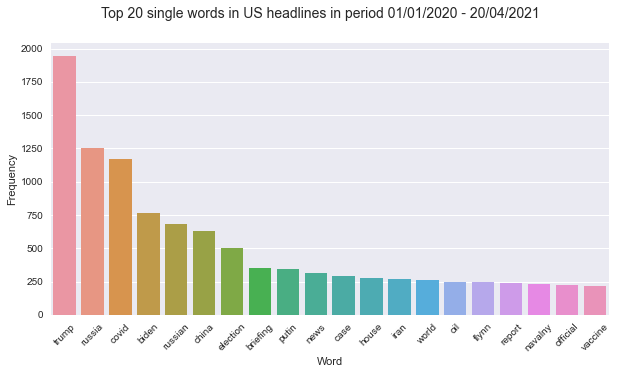

In [15]:
get_top_n_words(corpus_all, 20)

**Key insights:**


- Well, it is seen that the first 10 words stay the same and the name of former US president, Trump, has 5,5 times more  instances than the name of his Russian colleague even in context of Russia.

- What is new, Iran has also significant attention in addition to China. I suppose 'Iran' and 'oil' go together in headlines.

- Presence of 'Navalny' (Russian opposition leader Alexey Navalny) in top-20 gladden me very much.

In [16]:
#Most frequently occuring bi-grams
def get_top_bi_grams(corpus, n=None):
    vec = CountVectorizer(max_df = 0.8, stop_words = stop_words, ngram_range = (2,2), max_features=1000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
        
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    
    df = pd.DataFrame(words_freq[:n], columns = ["Bi-gram", "Frequency"])
    #print(df)
    fig = plt.figure(figsize = (10,5))
    plt.style.use('seaborn')
    plt.suptitle('Top {} bi-grams in US headlines in period 01/01/2020 - 20/04/2021'.format(n), fontsize = 14)

    plot = sns.barplot(x = "Bi-gram", y = "Frequency", data = df)
    labels = plot.get_xticklabels() 
    plot.set_xticklabels(labels, rotation=45)
    
    plt.show()
    

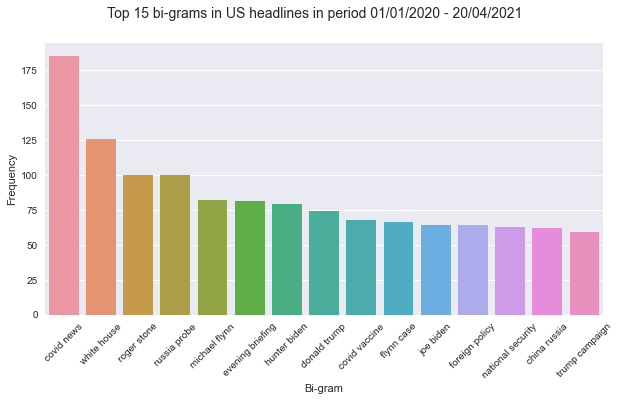

In [17]:
get_top_bi_grams(corpus_all, 15)

I would like to remind you that Russian propaganda systemetically impose an idea that Western countries, especially USA, are Russia's enemies and eager to destroy Russian values, economy and so on. The goal of this project is to identify what Americans and US media really think and discuss about Russia.


As it was expected,the list of top bi-grams is more informative and curious than list of frequent words.


**Key insights:**

- almost all collocations in top list are linked to internal affairs of the USA. As I have mentioned before, apparently, various US media discussed some role of Russia in US presidential election in 2020 or relationships between Russian and American political figures, like Michael Flynn, former US National Security Advisor, or Hunter Biden, son of the current US president Joe Biden;

- there are no names of Russian politicians, state organzations or Russian alternative of the White House - Kremlin. Even though 'Flynn case' was partially about conversations he had with Russian Ambassador Sergey Kislyak.  Once again, I presume that all affairs are mainly discussed from internal point of view;

- bi-grams 'Roger Stone' (American conservative political consultant and lobbyist)  and 'Russia probe' shared the third place with 100 instances in all headlines. So called Russia probe or Mueller probe is a special investigation of Russian interference in the 2016 US elections, of links between associates of Donald Trump and Russian officials. Roger Stone was found guilty on lying to Congress in the frame of this case. Apparently, it was a hot topic in 2020 and Americans were more worried about Russian interference in US internal affairs and not vice versa.

In [18]:
#Most frequently occuring tri-grams
def get_top_tri_grams(corpus, n = None):
    vec = CountVectorizer(max_df = 0.8, stop_words = stop_words, ngram_range = (3,3), max_features = 1000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
        
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(words_freq[:n], columns = ["Tri-gram", "Frequency"])
    #print(df)
    fig = plt.figure(figsize = (14,5))
    plt.style.use('seaborn')
    plt.suptitle('Top {} tri-grams in US headlines in period 01/01/2020 - 20/04/2021'.format(n), fontsize = 14)

    plot = sns.barplot(x = "Tri-gram", y = "Frequency", data = df)
    labels = plot.get_xticklabels() 
    plot.set_xticklabels(labels, rotation=45)
    
    plt.show()

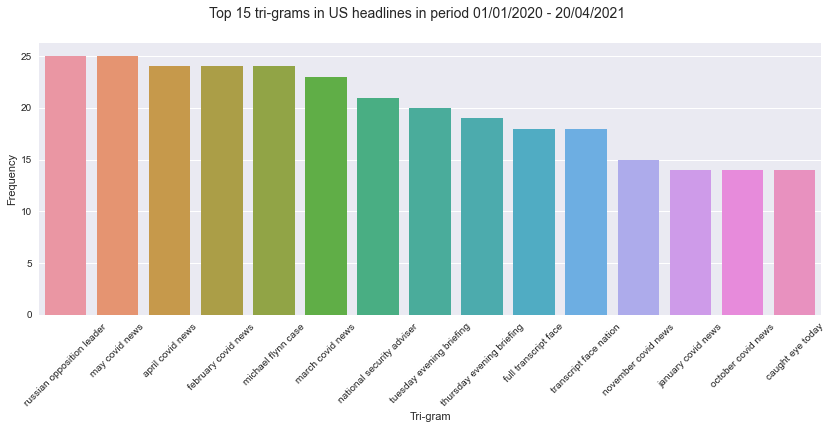

In [19]:
get_top_tri_grams(corpus_all, 15)

The list of top tri-grams does not almost add any new information except for mentioning Russian opposition leader, Alexey Navalny. His surname was also in the list of top-20 single words. I suppose Navalny case (he was allegedly poisoned by officers of Federal Security Service in August, 2020 and put in jail after returning to Russia in Februrary, 2021) is the only internal Russian topic discussed in American media. It should be added that Navalny case was widely covered by press all over the world and draw internationl attention in both 2020 and 2021. Nevertheless, there are only 25 instances of 'Russian opposition leader' in the dataset.


There is no surprise that monthly Covid-19 news take the majority of places in top-15 tri-grams list because it has been a pressing problem in the USA since the beginning of coronavirus pandemic.

## KEYWORDS  USING  TF-IDF


Previously, I calculated how many times words or collocations occured in headlines. The drawback of this analysing method is that simple counting does not consider context and does not indetify impact of a word in headline. This could be overcome with TF-IDF scores that highlight more important to the context words rather than words that are frequent across all headlines.


**TF-IDF** - is an approach of scoring that consists of 2 elements:

1. TF (term frequency) -  scoring of the frequency of the word in one headline;

2. IDF (inverse document frequency) - scoring of how rare the word is across all headlines.



TF = Number of times word (X) appears in a headline / Total number of words in a headline

IDF = log (Total number of headlines / Number of headlines with word (X) in them)

TF-IDF = TF * IDF



- For example, the word 'virus' appears 2 times in a headline consisting of 10 words. TF = 2/10 = 0,2.

- Then, we have 15 000 headlines and 1 500 of them contain at least 1 'virus' instance. IDF = log (15 000 / 1 500) = 1

- TF-IDF = 0,2 * 1 = 0,2



The words or bi-grams with the highest TF-IDF scores are the keywords in headlines.
**Ideally, TF-IDF should be applied for larger texts to extract valuable information**. For instance, if I gathered not only headlines, but also articles' abstracts, it would be much more interesting to apply TF-IDF scoring for keywords extraction. But almost 12 000 abstract + headlines will result in too large dataset. So, in this project I use TF-IDF to double-check intermediate results received from counting approach.

In [20]:
#Function for sorting tf_idf in descending order

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key = lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn = 10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only top n items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    
    return results

In [21]:
#compute the IDF values
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X)

# get feature names from CountVectorizer
feature_names = cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted - all headlines together
doc = str(corpus_all)
 
#generate tf-idf for the given document: calculate TF * IDF (already calculated)
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())

#extract only the top n
keywords = extract_topn_from_vector(feature_names,sorted_items,15)
 
# now print the results
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Keywords:
trump 0.365
russia 0.271
covid 0.259
biden 0.192
russian 0.175
china 0.165
election 0.14
briefing 0.106
putin 0.103
news 0.097
case 0.091
house 0.087
iran 0.087
world 0.084
oil 0.08


In [22]:
# 1. create a Bag of Word for BI-GRAMS - CountVectorizer
cv_bi = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 10000, ngram_range = (2,2))

#X will be used further in TF-IDF section.
X_bi = cv_bi.fit_transform(corpus_all)

# 2. compute the IDF values
tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X_bi)

# get feature names
feature_names_bi = cv_bi.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc = str(corpus_all)
 
#generate tf-idf for the given document: calculate TF * IDF (already calculated)
tf_idf_vector_bi = tfidf_transformer.transform(cv_bi.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector_bi.tocoo())

#extract only the top n
keywords = extract_topn_from_vector(feature_names_bi,sorted_items,15)
 
# now print the results
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Keywords:
covid news 0.247
white house 0.18
russia probe 0.148
roger stone 0.148
michael flynn 0.126
evening briefing 0.125
hunter biden 0.122
donald trump 0.116
covid vaccine 0.108
flynn case 0.105
china russia 0.103
joe biden 0.102
foreign policy 0.102
national security 0.101
trump campaign 0.096


In both cases, single words and bi-grams, TF-IDF scoring results are similar to those received by counting. The only difference is slight changes in order of key bi-grams. 

## CLUSTERING  HEADLINES

And last but no least part of the project - clustering of all headlines and exracting keywords inside each cluster. I use Mini-batch K-means clustering algorithm which is a variant of well-know K-means algorithm.

**Mini-batch** - is a subset of the input data, randomly sampled in each training iteration. Mini-batches reduce time for computation significantly and, according to documentation of Scikit-learn library, usinig mini-batches results in slightly worse results than using standard algorithm.

To identify the optimal amount of clusters I use Sum of squared errors (SSE) plot which displays SSE per number of clusters and Elbow method.


**Elbow method** - is a method to determine optimal number of clusters in a dataset by defining 'elbow point' on the plot after which  the curve visibly bends.

In [27]:
# TfidfVectorizer = CountVectorizer() + TfidfTransformer()
vectorizer = TfidfVectorizer(max_df = 0.8, stop_words = stop_words)

X_1 = vectorizer.fit_transform(corpus_all)

print('The shape of the matrix is {} rows and {} features.'.format(X_1.shape[0], X_1.shape[1]))

The shape of the matrix is 11941 rows and 10442 features.


You can see that it is very high-dimensional data and in order to avoid “curse of dimensionality” problem and reduce number of variables I apply one of the dimensionality reduction techniques.

**Curse of dimensionality** refers to a set of problems that arise due high-dimensional data. They could arise during analyzing or visualizing the data to identify patterns or while training machine learning models.

The specificity of high-dimensional matrix created from text data is that it's a sparse matrix (matrix that is comprised of mostly zero values). The algorithm that works efficiently with sparse data is **Singular Value Decomposition or SVD**.

SVD is one of the 'projection methods' which implies projecting the data to a lower dimensional subspace saving the “essence” of the data. To decide how many features should be in matrix I calculate the cumulative Explained Variance Ratio or the total percentage of variance explained by selected amount of components. 

In [30]:
def find_optimal_components(data, max_k):
    iters = range(100, max_k+1, 300)
    
    scores = []

    
    for k in iters:
        svd = TruncatedSVD(n_components = k, n_iter = 7, random_state = 42)
        svd.fit(data)
        score = svd.explained_variance_ratio_.sum()
        scores.append(score)
        print('Fit {} components'.format(k))
        
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, scores, marker='o')
    ax.set_xlabel('Number of components')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Sum of explained variance')
    
    

Fit 100 components
Fit 400 components
Fit 700 components
Fit 1000 components
Fit 1300 components
Fit 1600 components
Fit 1900 components
Fit 2200 components
Fit 2500 components
Fit 2800 components


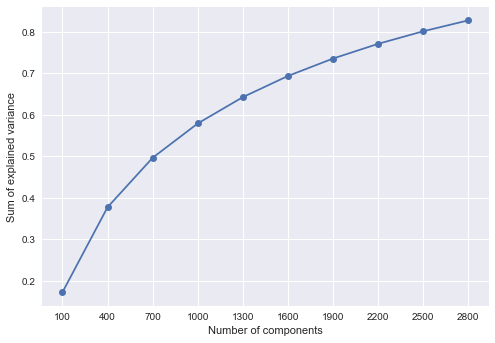

In [31]:
find_optimal_components(X_1, 2800)

In [32]:
svd = TruncatedSVD(n_components= 2500, n_iter=7, random_state=42)

X_1_svd = svd.fit_transform(X_1)
X_1_svd.shape

(11941, 2500)

I choose the threshold to be 0.80 and it is reached with 2 500 features. It means that 80% of variance are explained by these 2 500 features.


The next step is to determine the optimal number of clusters. As I have no idea how many clusters can be identified in the dataset of headlines, plotting Sum of squared errors can be useful.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


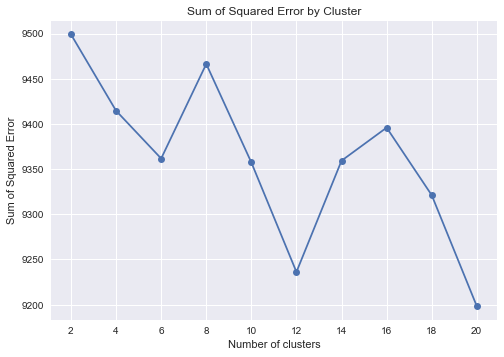

In [33]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    scores = []
    for k in iters:
        score = MiniBatchKMeans(n_clusters = k, max_iter = 100, batch_size=600, random_state=20).fit(data).inertia_
        scores.append(score)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, scores, marker='o')
    ax.set_xlabel('Number of clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Sum of Squared Error')
    ax.set_title('Sum of Squared Error by Cluster')
    
find_optimal_clusters(X_1_svd, 20)


In [38]:
cls = MiniBatchKMeans(n_clusters=12, batch_size=600, random_state=20)
clusters = cls.fit_predict(X_1_svd)

In [39]:
headlines['clusters_svd'] = cls.labels_
headlines

,headline,clusters_svd
0,The last chance to save Alexey Navalny,0
1,Blinken warns US is falling behind China in ra...,1
2,China and Russia 'weaponized' QAnon conspiracy...,5
3,Two Russian agents have been linked to a high-...,3
4,Here we go! Earnings season is underway,1
...,...,...
11936,Rosenstein: If I Knew Then What I Know Now I W...,1
11937,Adam Milhous Schiff: Is There a Nixon in the H...,1
11938,Presented by Partnership for America's Health ...,1
11939,"Trump Barrels Into 2020 Campaign, Emboldened A...",5


Wow! It is very unusual, but straightforward plot. It is obvious that optimal amount of clusters is 12. Even though 20 clusters option performs better, it might be too much to split headlines into 20 parts.


Previous calculations showed that there is no significant difference in keywords whether to use counting of frequent words or TF-IDF scores. So, using Bags of Words model per each of 12 clusters I extract keywords to analyse what topics were disclosed in these clusters of headlines. Surprisingly, this approach brought to light new and previously not discussed topic.

In [41]:
def keywords_per_cluster_svd(df, n_words, n_clusters):
    
    for j in range(n_clusters):
        df_cluster = headlines[headlines.clusters_svd == j].drop(columns = 'clusters_svd').reset_index(drop=True)
        corpus = cleaning(df_cluster)

        vec = CountVectorizer(ngram_range = (1,2)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 

        words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:n_words]

        result = ', '.join(x[0] for x in words_freq)
        
        print('\nCluster {}, \n{} articles in cluster.'.format(j+1, headlines[headlines.clusters_svd == j].headline.count()))
        print(result)
            

In [42]:
keywords_per_cluster_svd(headlines, 12, 12)


Cluster 1, 
221 articles in cluster.
navalny, russia, poisoning, russian, putin, alexey, alexey navalny, critic, aleksei, aleksei navalny, navalny poisoning, kremlin

Cluster 2, 
7175 articles in cluster.
covid, biden, china, election, world, oil, iran, house, chinese, putin, vaccine, time

Cluster 3, 
283 articles in cluster.
case, flynn, flynn case, covid, covid case, trump, michael, michael flynn, judge, court, appeal, drop

Cluster 4, 
724 articles in cluster.
russian, america, trump, biden, bounty, russian bounty, putin, disinformation, intelligence, report, election, interference

Cluster 5, 
204 articles in cluster.
news, covid, covid news, april, march, may, may covid, april covid, february, february covid, march covid, october

Cluster 6, 
2578 articles in cluster.
trump, russia, biden, covid, election, china, putin, probe, russia probe, campaign, intelligence, official

Cluster 7, 
1 articles in cluster.
covid, democratic, primary, love, blind, tuesday, evening, briefing, co